In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [3]:
device = torch.device('cpu:0')

In [2]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [4]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [17]:
# Load results of the fitting procedure

subject = 1
# fitting_type = 'gabor_PCA_36ori_12sf'
# fitting_type = 'gabor_PCA_36ori_12sf_SHUFFLEIMAGES'
# fitting_type = 'gabor_PCA_36ori_12sf_RANDOMIMAGES'
fitting_type = 'gabor_PCA_36ori_12sf_RANDOMVOXELDATA'


root = os.path.dirname(os.path.dirname(os.getcwd()))
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = files_in_dir
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1]

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

IndexError: list index out of range

In [18]:
subfolder2load

'/user_data/mmhender/imStat/model_fits/S01/gabor_PCA_36ori_12sf_RANDOMVOXELDATA/Jun-17-2021_0541'

In [6]:
# Pulling out useful elements from the saved data

feature_table = out['feature_table']
orient_list = np.round(np.array(feature_table['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
val_r2 = out['val_r2']
best_params = out['best_params']
best_losses = out['best_losses']

features_each_model_val = out['features_each_model_val']
features_each_model_val = out['features_pca_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
voxel_pca_feature_correlations_val = out['voxel_pca_feature_correlations_val']
  
pc = out['pc']
pca_wts = pc[0]
pct_var_expl = pc[1]
n_comp_needed = pc[3]
pca_pre_mean = pc[4]

zscore_features = out['zscore_features']
print('zscore_features=%s\n'%zscore_features)
nonlin_fn = out['nonlin_fn']
padding_mode = out['padding_mode']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_model_inds = best_params[5]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

# also listing roi names here
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
n_rois = len(group_names)


zscore_features=True

(11694, 3)
(11694, 432)


In [6]:
feature_table

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.087266,2.8,12.0,2.891
2,3.0,12,0.174533,2.8,12.0,2.891
3,3.0,12,0.261799,2.8,12.0,2.891
4,3.0,12,0.349066,2.8,12.0,2.891
...,...,...,...,...,...,...
427,72.0,297,2.705260,2.8,12.0,2.891
428,72.0,297,2.792527,2.8,12.0,2.891
429,72.0,297,2.879793,2.8,12.0,2.891
430,72.0,297,2.967060,2.8,12.0,2.891


Text(0.5, 0.98, 'S01, gabor_PCA_36ori_12sf_RANDOMIMAGES')

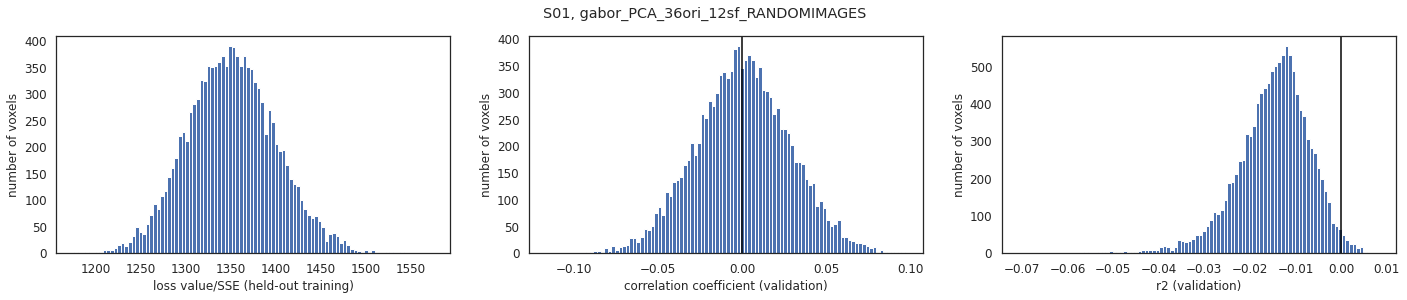

In [7]:
# Plot summary of performance

plt.figure(figsize=(24,4));

plt.subplot(1,3,1)
plt.hist(best_losses,100)
# plt.xlim([500,2000])
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');

plt.subplot(1,3,2)
plt.hist(val_cc,100)
# plt.xlim([-0.2, 0.8])
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(1,3,3)
plt.hist(val_r2,100)
# plt.plot(np.sort(val_cc)[::-1],'-o')
plt.axvline(0,color='k')
# plt.xlim([-0.2, 0.8])
plt.ylabel('number of voxels')
plt.xlabel('r2 (validation)')

plt.suptitle('S%02d, %s'%(subject, fitting_type))

Text(0.5, 0.98, 'Correlation coef. on validation set\nS01, gabor_PCA_36ori_12sf_RANDOMIMAGES')

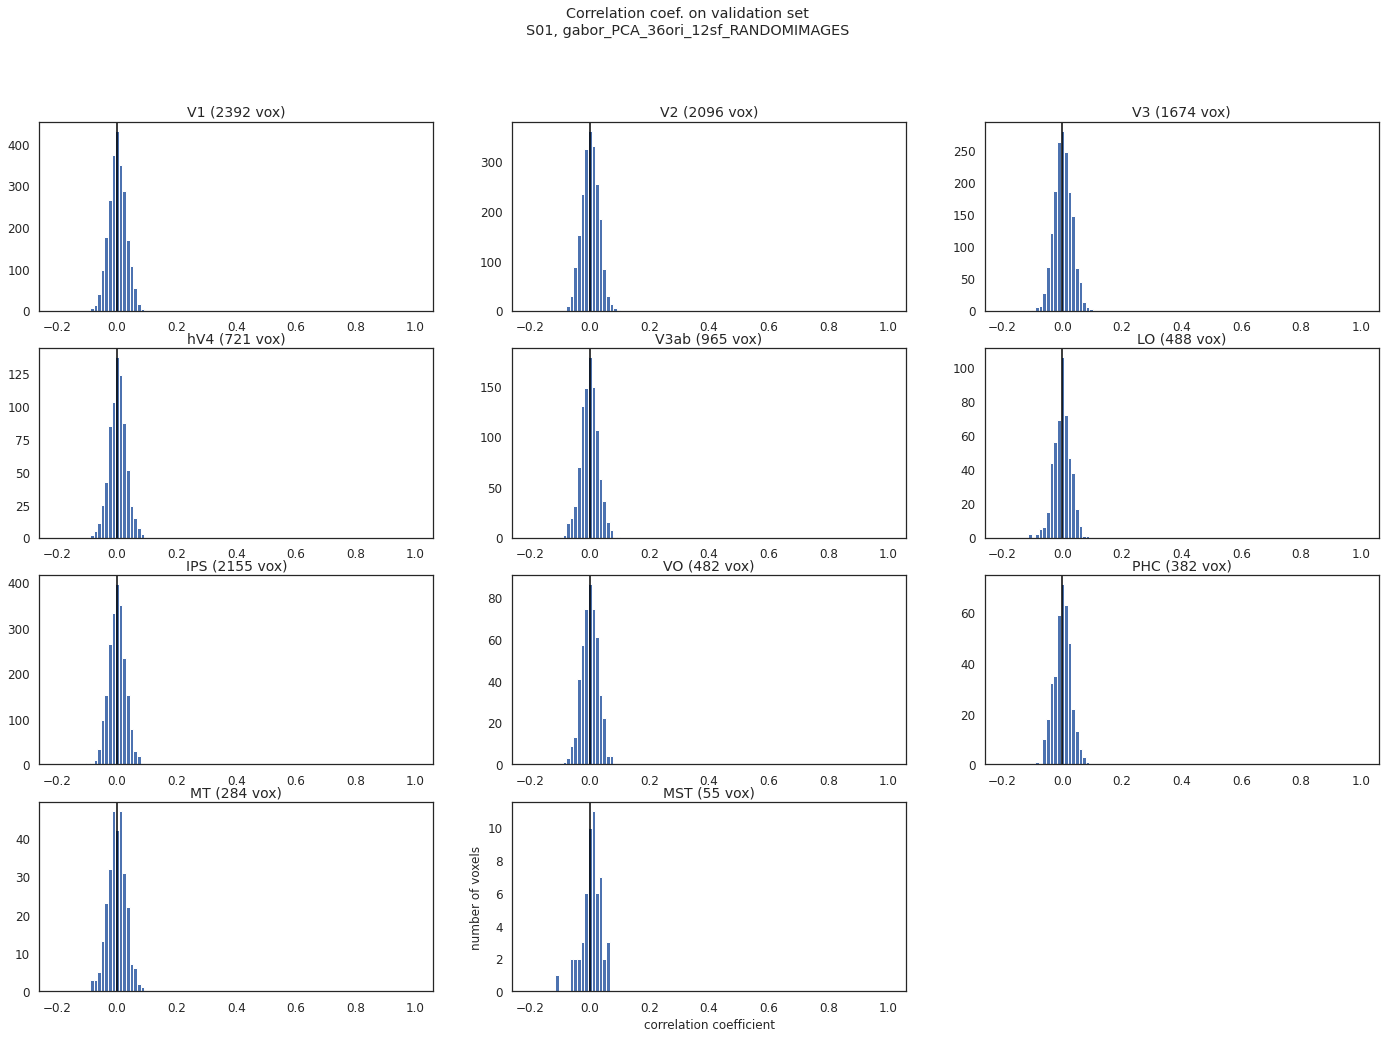

In [8]:
# Plot correlation coefficient for each ROI separately.

plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-2:
        plt.xlabel('correlation coefficient')
        plt.ylabel('number of voxels')
#     else:
#         plt.xticks([])
#         plt.yticks([])
        
    plt.axvline(0,color='k')
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d, %s'%(subject, fitting_type))

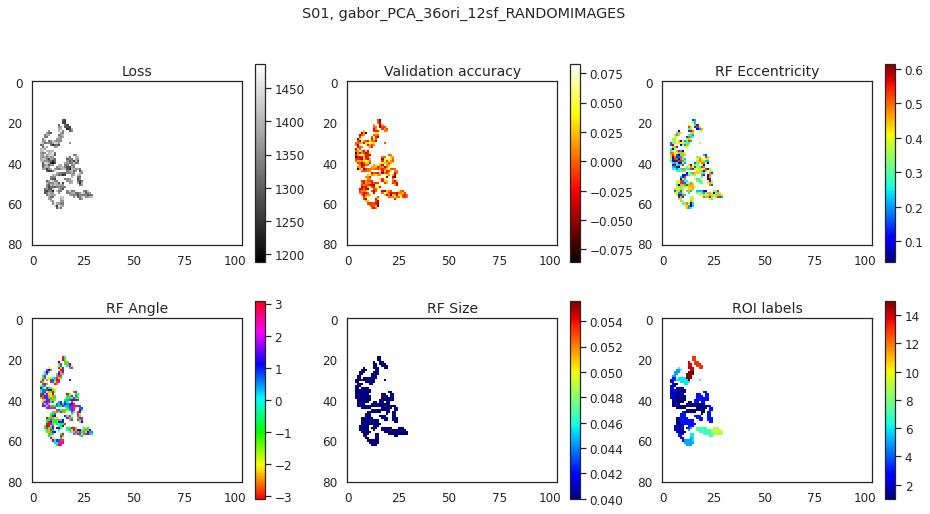

In [9]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

sys.path.append(os.path.join(root,'code'))
from utils import file_utility

volume_loss = file_utility.view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = file_utility.view_data(brain_nii_shape, voxel_idx, val_cc)
volume_ecc  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ecc)
volume_ang  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ang)
volume_size = file_utility.view_data(brain_nii_shape, voxel_idx, best_size)
volume_roi = file_utility.view_data(brain_nii_shape, voxel_idx, voxel_roi)

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

plt.suptitle('S%02d, %s'%(subject, fitting_type));

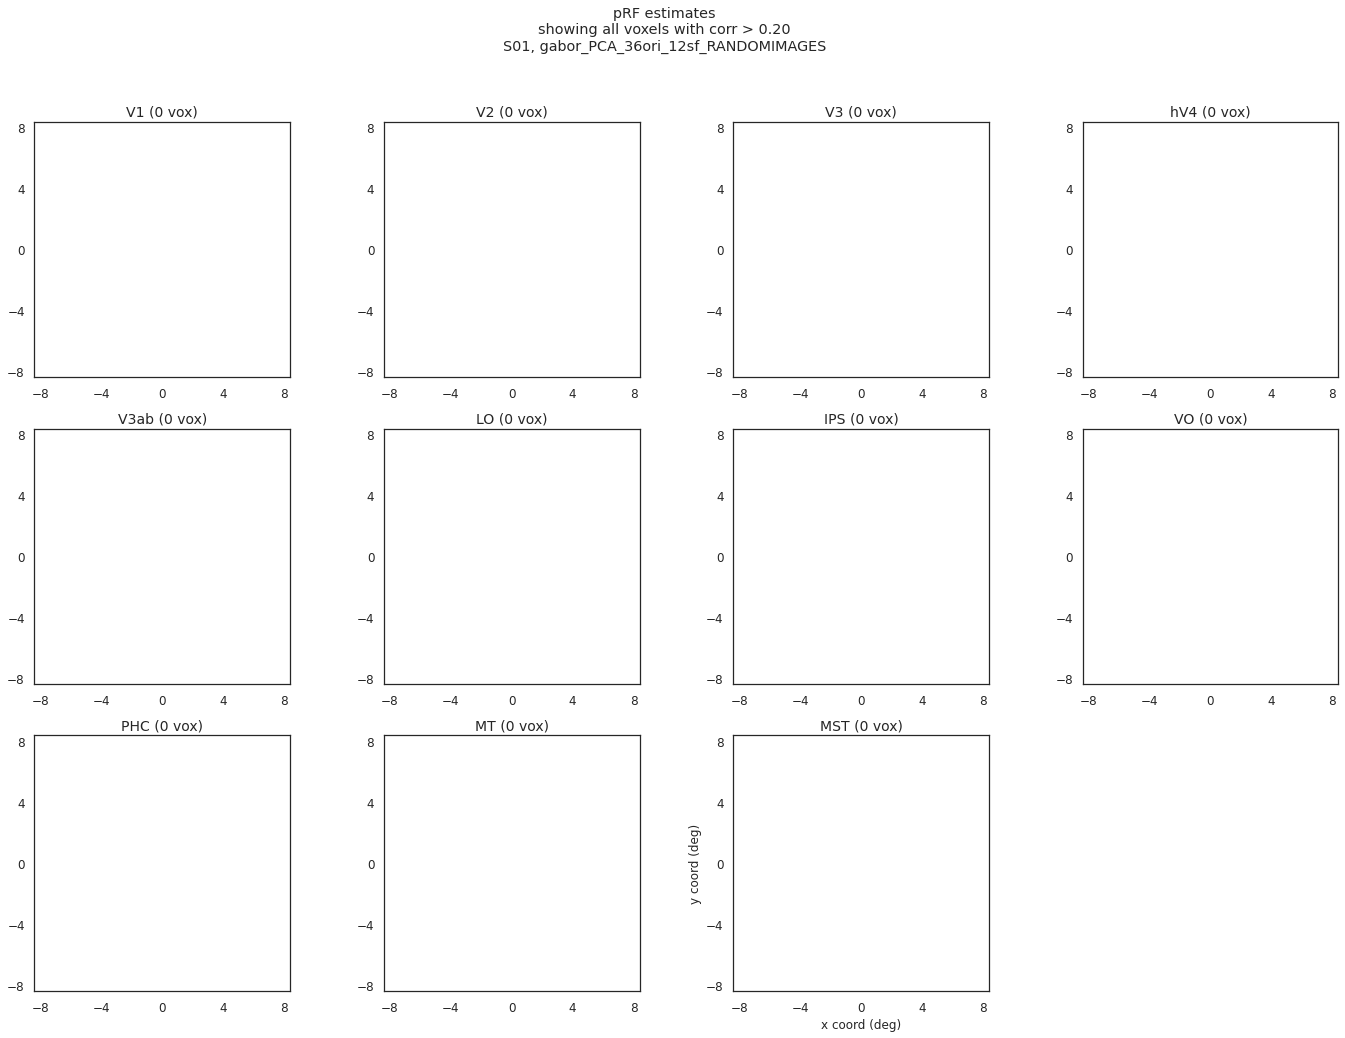

In [10]:
# Plot spatial RF estimates
import matplotlib

eccen_deg = 8.4
best_models_deg = best_models*eccen_deg

npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil(n_rois/npy))

plt.figure(figsize=(24,16))

cc_cutoff = 0.20

for rr in range(n_rois-1):
# for rr in range(1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.where(np.logical_and(inds_this_roi, abv_thresh))[0]
    
    plt.subplot(npx,npy,rr+1)
    ax = plt.gca()

    for vi, vidx in enumerate(inds2use):
       
        plt.plot(best_models_deg[vidx,0], best_models_deg[vidx,1],'.',color='k')
        circ = matplotlib.patches.Circle((best_models_deg[vidx,0], best_models_deg[vidx,1]), best_models_deg[vidx,2], color = [0.8, 0.8, 0.8], fill=False)
        ax.add_artist(circ)
   
    plt.axis('square')
    
    plt.xlim([-eccen_deg, eccen_deg])
    plt.ylim([-eccen_deg, eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    if rr==n_rois-2:
        plt.xlabel('x coord (deg)')
        plt.ylabel('y coord (deg)')
    plt.title('%s (%d vox)'%(group_names[rr], len(inds2use)))

plt.suptitle('pRF estimates\nshowing all voxels with corr > %.2f\nS%02d, %s'%(cc_cutoff, subject, fitting_type));


121


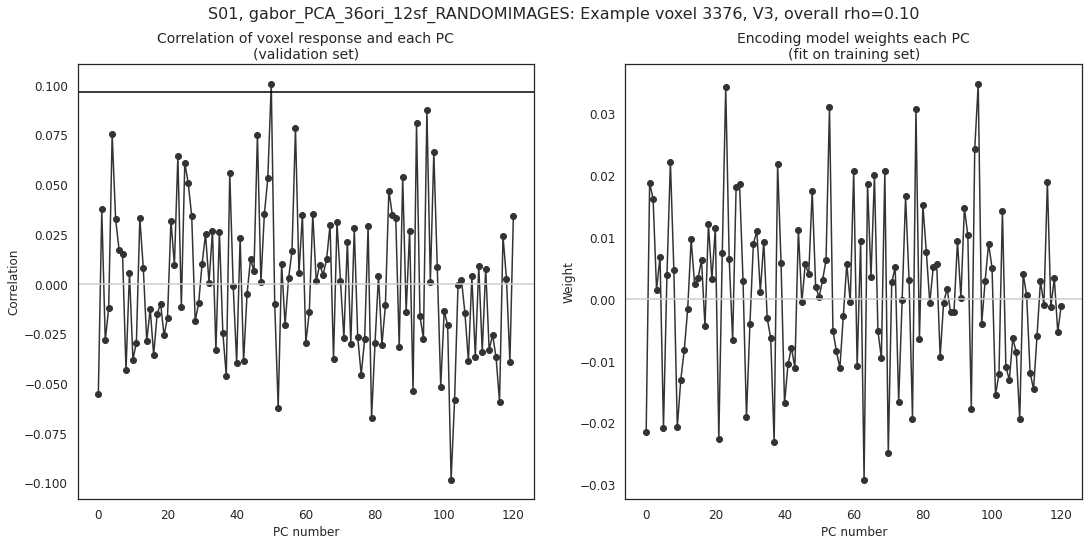

In [11]:
# Plotting orientation tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
ncomp2use = n_comp_needed[best_model_inds[vidx]]
assert np.where(np.isnan(voxel_pca_feature_correlations_val[vidx,:]))[0][0]==ncomp2use
assert feature_weights[vidx,ncomp2use]==0.0 and not feature_weights[vidx,ncomp2use-1]==0.0

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(voxel_pca_feature_correlations_val[vidx,:],'-o',color=[0.2, 0.2, 0.2])
print(np.argmax(voxel_pca_feature_correlations_val[vidx,:]))
plt.xlabel('PC number')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and each PC\n(validation set)')
plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.subplot(1,2,2)
plt.plot(np.arange(0,ncomp2use,1), feature_weights[vidx,0:ncomp2use],'-o',color=[0.2, 0.2, 0.2])
plt.xlabel('PC number')
plt.ylabel('Weight')
plt.title('Encoding model weights each PC\n(fit on training set)')
plt.axhline(0, color=[0.8, 0.8, 0.8])

roi_ind = np.where([np.isin(voxel_roi[vidx], group[ii]) for ii in range(len(group))])[0][0]

plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f'%(subject, fitting_type,  vidx, group_names[roi_ind], val_cc[vidx]),fontsize=16);


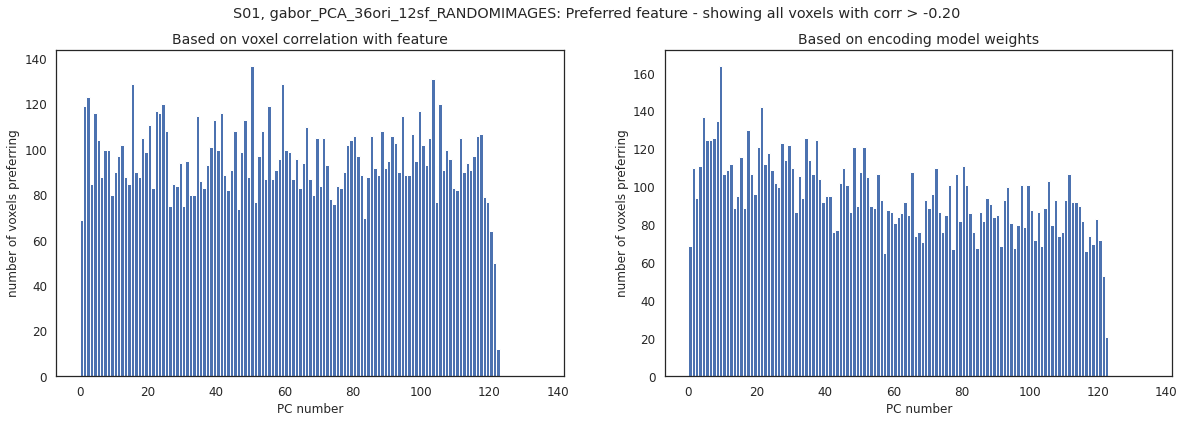

In [12]:
# Plot histogram of the preferred feature for all voxels

plt.figure(figsize=(20,6))

cc_cutoff = -0.2
abv_thresh = val_cc>cc_cutoff

best_pc_wts = np.nanargmax(feature_weights, axis=1)
best_pc_corr  = np.nanargmax(voxel_pca_feature_correlations_val, axis=1)

plt.subplot(1,2,1)
h = plt.hist(best_pc_corr[abv_thresh], bins=np.arange(0,np.max(n_comp_needed)));  
plt.xlabel('PC number')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')
   
plt.subplot(1,2,2)
h = plt.hist(best_pc_wts[abv_thresh], bins=np.arange(0,np.max(n_comp_needed)));  
plt.xlabel('PC number')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')
   
plt.suptitle('S%02d, %s: Preferred feature - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

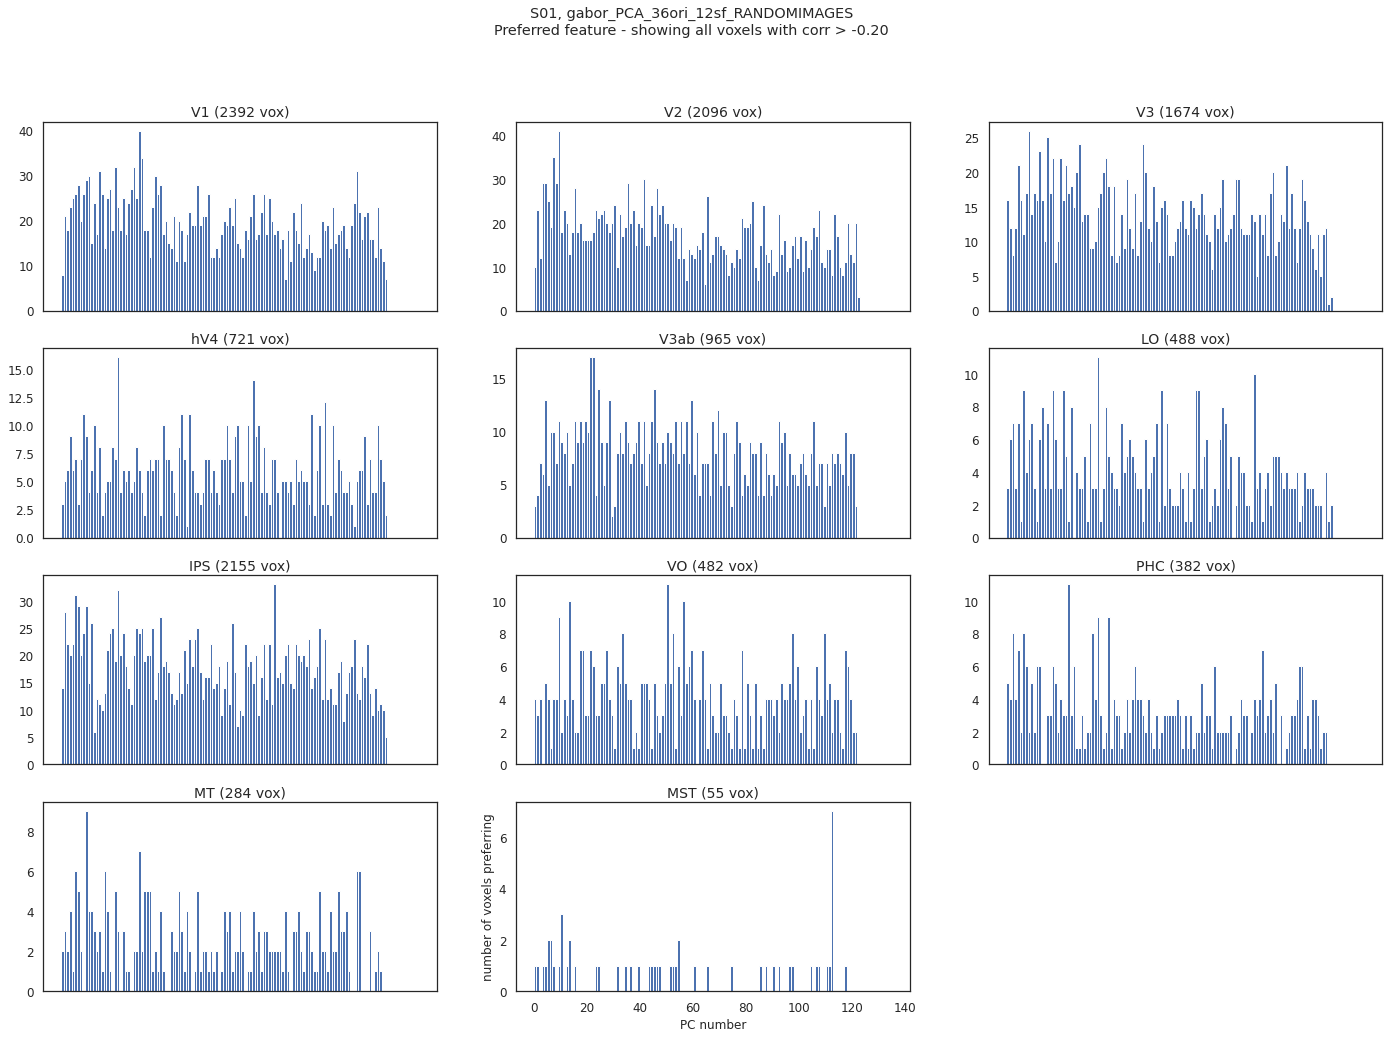

In [13]:
# Plot histogram of the preferred feature, (based on weights) separated by different ROIs

plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

cc_cutoff = -0.2

best_pc_wts = np.nanargmax(feature_weights, axis=1)

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(best_pc_wts[inds2use], bins=np.arange(0,np.max(n_comp_needed)));  
 
    if rr==n_rois-2:
        plt.xlabel('PC number')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
#         plt.yticks([])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('S%02d, %s\nPreferred feature - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

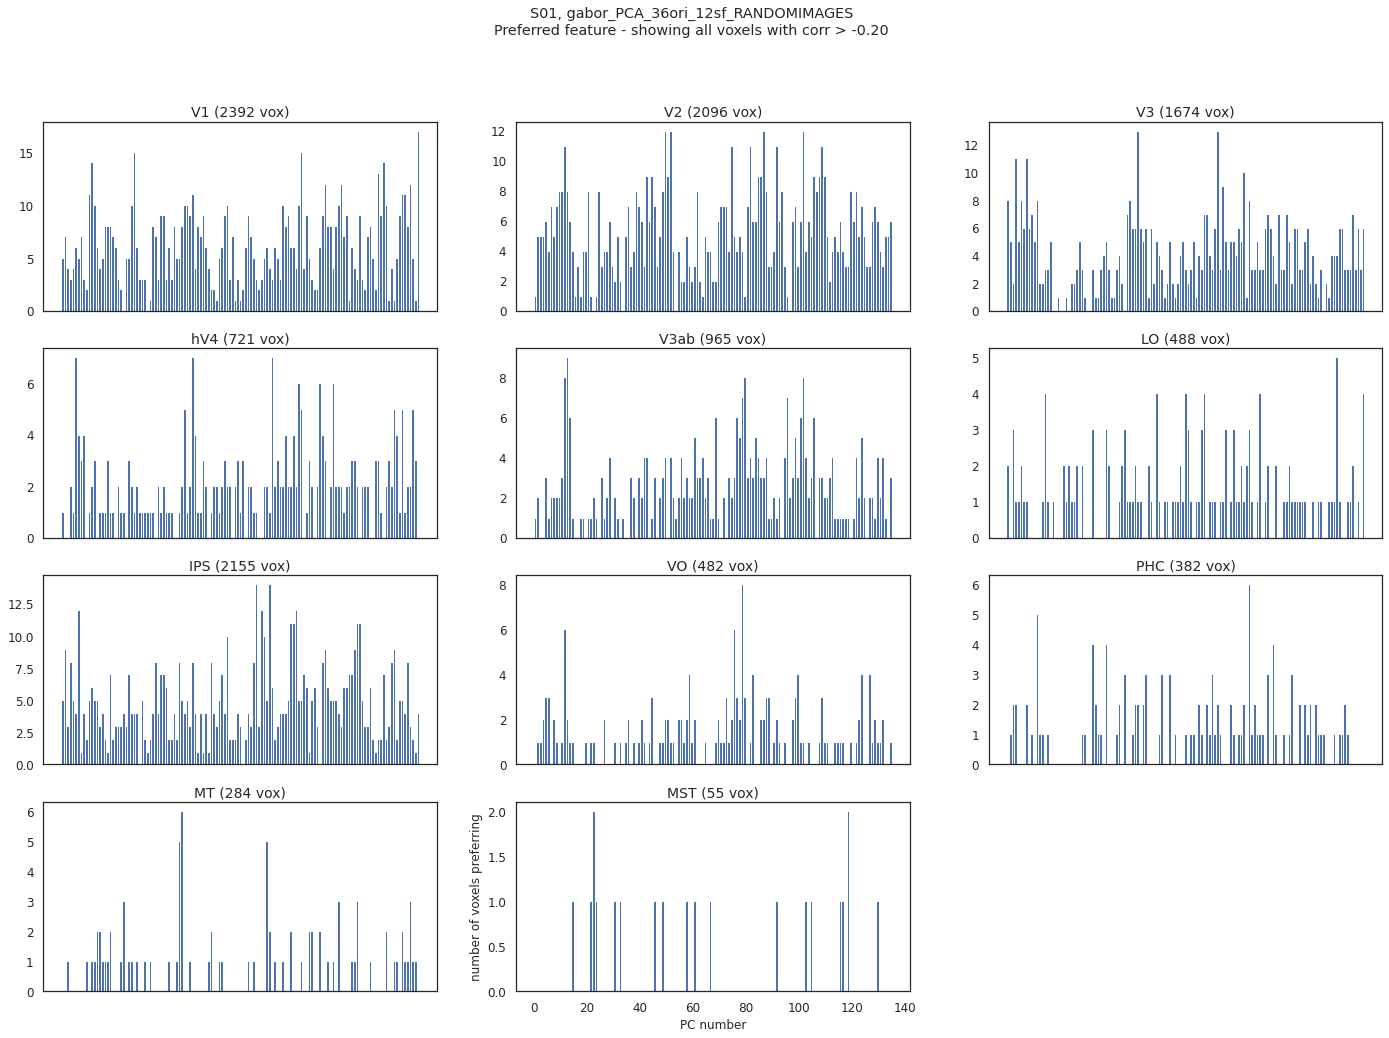

In [14]:
# Plot histogram of the preferred feature, (based on corr coef) separated by different ROIs

plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

cc_cutoff = -0.2

best_pc_corr = np.nanargmax(voxel_feature_correlations_val, axis=1)

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(best_pc_corr[inds2use], bins=np.arange(0,np.max(n_comp_needed)));  
 
    if rr==n_rois-2:
        plt.xlabel('PC number')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
#         plt.yticks([])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('S%02d, %s\nPreferred feature - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

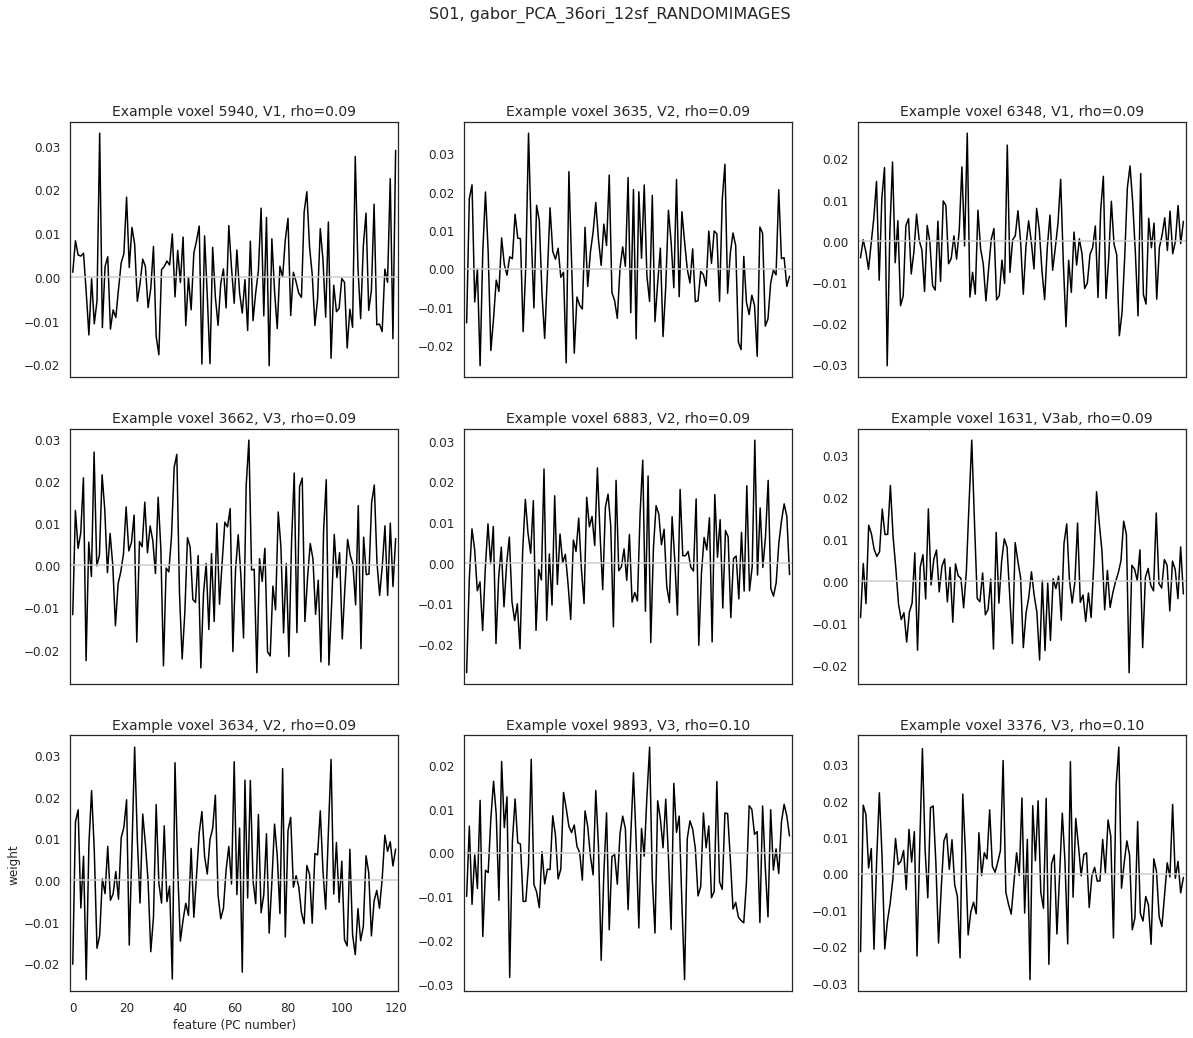

In [15]:
# Plotting weights for all features, several example voxels

n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
# vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    ncomp2use = n_comp_needed[best_model_inds[vv]]
    weights = feature_weights[vv,0:ncomp2use]
    plt.plot(weights,color='k')
    plt.xlim([-1, np.max(ncomp2use)])

    plt.axhline(0,color=[0.8, 0.8, 0.8])
   
    if vi==(npx-1)*npy:
        plt.xlabel('feature (PC number)')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])

    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f'%(vv,group_names[roi_ind], val_cc[vv]))

plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);

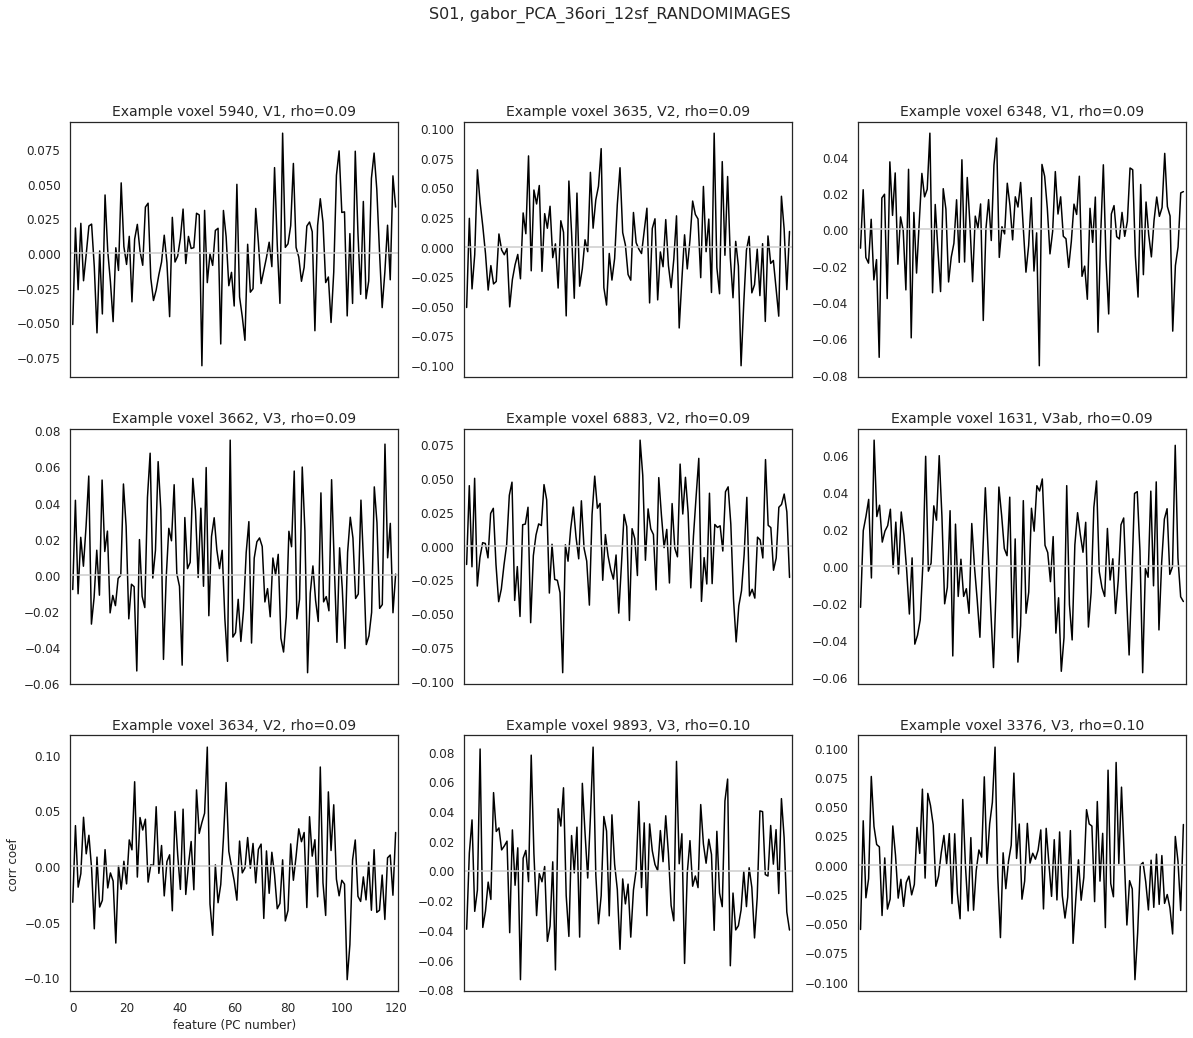

In [16]:
# Plotting corr coefs for all features, several example voxels

n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
# vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    ncomp2use = n_comp_needed[best_model_inds[vv]]
    corrs = voxel_pca_feature_correlations_val[vv,0:ncomp2use]
    plt.plot(corrs,color='k')
    plt.xlim([-1, np.max(ncomp2use)])

    plt.axhline(0,color=[0.8, 0.8, 0.8])
   
    if vi==(npx-1)*npy:
        plt.xlabel('feature (PC number)')
        plt.ylabel('corr coef')
    else:
        plt.xticks([]); 
#         plt.yticks([])

    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f'%(vv,group_names[roi_ind], val_cc[vv]))

plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);